# SNN that detects Network bursts in a single channel
This notebook is a simple example of how to use a Spiking Neural Network (SNN) to detect network bursts in a single channel. 

## Definition of a network burst
A network burst is a sequence of spikes that occur in a short time window. The definition of a network burst is not unique and depends on the context. 

In this notebook, we will **consider a network burst any sequence of spikes that occurs within 10 ms**

In [73]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense

LIF?

Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

In [74]:
# Define the number of neurons in each LIF Layer
n1 = 1   # 1 neuron in the first layer
n2 = 1   # 1 neuron in the second layer

In [75]:
import numpy as np

v_th = 4
v_init = 0
dv = 0.1
du = 0.3

# Create Processes
lif1 = LIF(shape=(n1,),  # There is 1 neuron
           vth=v_th,  # TODO: Verify these initial values
           v=v_init,
           dv=dv,    # Inverse of decay time-constant for voltage decay
           du=du,  # Inverse of decay time-constant for current decay
           bias_mant=0,
           bias_exp=0,
           name="lif1")

lif2 = LIF(shape=(n2,),
           vth=v_th,
           v=v_init,
           dv=dv,
           du=du,
           bias_mant=0,
           bias_exp=0,
           name="lif2") 

In [76]:
for proc in [lif1, lif2]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: lif1  Port Name: a_in  Size: 1
Proc: lif1  Port Name: s_out Size: 1
Proc: lif2  Port Name: a_in  Size: 1
Proc: lif2  Port Name: s_out Size: 1


## Create the Custom Input Layer

### Define function to read the input data from the csv file and generate the corresponding spike events

In [77]:
import pandas as pd

def read_spike_events(file_path: str):
    """Reads the spike events from the input file and returns them as a numpy array

    Args:
        file_path (str): name of the file containing the spike events
    """
    spike_events = []

    try:
        # Read the spike events from the file
        df = pd.read_csv(file_path, header=None)

        # Detect errors
        if df.empty:
            raise Exception("The input file is empty")

        # Convert the scientific notation values to integers if any exist
        df = df.applymap(lambda x: int(float(x)) if (isinstance(x, str) and 'e' in x) else x)

        # Convert the dataframe to a numpy array
        spike_events = df.to_numpy()
        return spike_events[0]
    except Exception as e:
        print("Unable to read the input file: ", file_path, " error:", e)

    return spike_events

In [78]:
# Call the function to read the spike events
file_path = "./data/custom_activations_burst.csv"
spike_events = read_spike_events(file_path)
print("Spike events: ", spike_events.shape, spike_events[:10])

Spike events:  (6,) [ 5 20 21 33 45 46]


### Define the SpikeEvent Generator Interface

In [79]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

class SpikeEventGen(AbstractProcess):
    """Input Process that generates spike events based on the input file

    Args:
        shape (tuple): Shape of the output port
        file_name (str): Name of the file containing the spike events
    """
    def __init__(self, shape: tuple, spike_events: np.ndarray, name: str) -> None:
        super().__init__(name=name)
        self.s_out = OutPort(shape=shape)
        self.spike_events = Var(shape=spike_events.shape, init=spike_events)

### Implement the `SpikeEventGenerator` Model

In [80]:
from lava.magma.core.model.py.model import PyLoihiProcessModel  # Processes running on CPU inherit from this class
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

@implements(proc=SpikeEventGen, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeEventGenModel(PyLoihiProcessModel):
    """Spike Event Generator Process implementation running on CPU (Python)
    Args:
    """
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)   # IT IS POSSIBLE TO SEND FLOATS AFTER ALL
    spike_events: np.ndarray = LavaPyType(np.ndarray, np.ndarray)   # TODO: Check if we should keep it as a numpy array, or transform it to a list

    def __init__(self, proc_params) -> None:
        super().__init__(proc_params=proc_params)
        # print("spike events", self.spike_events.__str__())    # TODO: Check why during initialization the variable prints the class, while during run it prints the value
        self.curr_spike_idx = 0     # Index of the next spiking event to send
        self.virtual_time_step_interval = 1  # 1000    # Arbitrary time between time steps (in microseconds). This is not a real time interval (1000ms = 1s)
        self.init_offset = 0        # 698995               # Arbitrary offset to start the simulation (in microseconds)

    def run_spk(self) -> None:
        spike_data = np.zeros(self.s_out.shape) # Initialize the spike data to 0
        
        # Use random spikes to test it
        # spike_data[0] = np.random.random()  # Only 1 neuron is sending data (spikes)
        # self.curr_spike_idx += 1

        # Use the spike events from the file
        # print("spike events: ", self.spike_events[:5])
        # TODO: For now we are using the time_step as the time measurement that will simulate real-time activity. It would be better to have access to the running time
        
        #print("time step:", self.time_step)
        # If the current simulation time is greater than the next spike event, send a spike
        currTime = self.init_offset + self.time_step*self.virtual_time_step_interval
        if ( self.curr_spike_idx < len(self.spike_events) ) and currTime >= self.spike_events[self.curr_spike_idx]:
            spike_data[0] = 1.0   # Send a spike  (value corresponds to the punctual current of the spike event?)
            # spike_data[1] = 0.5   # Send a spike  (value corresponds to the punctual current of the spike event?)
            print(f"sending spike event at time: {currTime}({self.time_step}) spike idx: {self.curr_spike_idx} spike time: {self.spike_events[self.curr_spike_idx]}")
            self.curr_spike_idx += 1

        # Send spikes
        # print("sending spike_data: ", spike_data, " at step: ", self.time_step)
        self.s_out.send(spike_data)

        # Stop the Process if there are no more spike events to send. (It will stop all the connected processes)
        # TODO: Should it be another process that stops the simulation? Such as the last LIF process
        # if self.curr_spike_idx >= 5: # len(self.spike_events):
        #    self.pause()


## Connect the Custom Input Layer to the middle layer

To define the connectivity between the `SpikeGenerator` and the first `LIF` population, we use another `Dense` Layer.

In [81]:
# Create the Input Process
spike_event_gen = SpikeEventGen(shape=(n1,), spike_events=spike_events, name="CustomInput")

# Instantiante a Dense Layer to connect the SpikeEventGen to the middle layer
# dense_input = Dense(weights=np.eye(n1), name="DenseInput")     # 1-1 connectivity with the Middle Layer (should be a 2x2 matrix right now)
dense_input = Dense(weights=np.array([[1.0, 0], [0, 1.0]]), name="DenseInput")


# If I connect the SpikeEventGen to the Dense Layer, the a_out value of the custom input will be rounded to 0 or 1 in the Dense Layer (it will not be a float) 
# Connect the SpikeEventGen to the Dense Layer
# spike_event_gen.s_out.connect(dense_input.s_in)

# Connect the Dense_Input to the LIF1 Layer
# dense_input.a_out.connect(lif1.a_in)

# Connect the SpikeEventGen layer directly to the LIF1 layer
spike_event_gen.s_out.connect(lif1.a_in)

# Connect the LIF1 Layer to the LIF2 Layer
lif1.s_out.connect(lif2.a_in)   # Connect the output of the first LIF layer to the input of the second LIF layer

### Take a look at the connections in the Input Layer

In [82]:
for proc in [spike_event_gen, dense_input, lif1, lif2]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: CustomInput Port Name: s_out Size: 1
Proc: DenseInput Port Name: s_in  Size: 2
Proc: DenseInput Port Name: a_out Size: 2
Proc: lif1  Port Name: a_in  Size: 1
Proc: lif1  Port Name: s_out Size: 1
Proc: lif2  Port Name: a_in  Size: 1
Proc: lif2  Port Name: s_out Size: 1


In [83]:
# Weights of the Input Dense Layer
dense_input.weights.get()

array([[1., 0.],
       [0., 1.]])

### Record Internal Vars over time
To record the evolution of the internal variables over time, we need a `Monitor`. For this example, we want to record the membrane potential of the `LIF` Layer, hence we need 1 `Monitors`.

We can define the `Var` that a `Monitor` should record, as well as the recording duration, using the `probe` function

In [84]:
from lava.proc.monitor.process import Monitor

monitor_lif1_v = Monitor()
monitor_lif1_u = Monitor()
monitor_lif2_v = Monitor()
monitor_lif2_u = Monitor()

num_steps = 50        # 26500     # TODO: Check the number of steps to run the simulation for

# Connect the monitors to the variables we want to monitor
monitor_lif1_v.probe(lif1.v, num_steps)
monitor_lif1_u.probe(lif1.u, num_steps)
monitor_lif2_v.probe(lif2.v, num_steps)
monitor_lif2_u.probe(lif2.u, num_steps)

## Execution
Now that we have defined the network, we can execute it. We will use the `run` function to execute the network.

### Run Configuration and Conditions

In [85]:
from lava.magma.core.run_conditions import RunContinuous, RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

# run_condition = RunContinuous()   # TODO: Change to this one
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")   # TODO: Check why we need this select_tag="floating_pt"

### Execute

In [86]:
lif1.run(condition=run_condition, run_cfg=run_cfg)

sending spike event at time: 5(5) spike idx: 0 spike time: 5
sending spike event at time: 20(20) spike idx: 1 spike time: 20
sending spike event at time: 21(21) spike idx: 2 spike time: 21
sending spike event at time: 33(33) spike idx: 3 spike time: 33
sending spike event at time: 45(45) spike idx: 4 spike time: 45
sending spike event at time: 46(46) spike idx: 5 spike time: 46


### Retrieve recorded data

In [87]:
data_lif1_v = monitor_lif1_v.get_data()
data_lif1_u = monitor_lif1_u.get_data()
data_lif2_v = monitor_lif2_v.get_data()
data_lif2_u = monitor_lif2_u.get_data()

data_lif1 = data_lif1_v.copy()
data_lif1["lif1"]["u"] = data_lif1_u["lif1"]["u"]   # Merge the dictionaries to contain both voltage and current

data_lif2 = data_lif2_v.copy()
data_lif2["lif2"]["v"] = data_lif2_u["lif2"]["u"]   # Merge the dictionaries to contain both voltage and current


In [88]:
data_lif1

{'lif1': {'v': array([[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [1.        ],
         [1.6       ],
         [1.93      ],
         [2.08      ],
         [2.1121    ],
         [2.06896   ],
         [1.979713  ],
         [1.864096  ],
         [1.73533441],
         [1.60215458],
         [1.47018664],
         [1.34294125],
         [1.22248841],
         [1.10992847],
         [1.00571785],
         [1.90989363],
         [3.42222756],
         [0.        ],
         [0.83462841],
         [1.33540546],
         [1.61083284],
         [1.7360271 ],
         [1.76281867],
         [1.7268128 ],
         [1.65232472],
         [1.55582749],
         [1.44835941],
         [1.33720373],
         [2.22705955],
         [2.72085692],
         [2.95032356],
         [3.00637784],
         [2.9515007 ],
         [2.82838308],
         [2.66596748],
         [2.48366664],
         [2.2943071 ],
         [2.10618138],
         [1.92447674]

In [89]:
data_lif2

{'lif2': {'v': array([[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [1.00000000e+00],
         [7.00000000e-01],
         [4.90000000e-01],
         [3.43000000e-01],
         [2.40100000e-01],
         [1.68070000e-01],
         [1.17649000e-01],
         [8.23543000e-02],
         [5.76480100e-02],
         [4.03536070e-02],
         [2.82475249e-02],
         [1.97732674e-02],
         [1.38412872e-02],
         [9.68890104e-03],
         [6.78223073e-03],
         [4.747

In [90]:
# Check the shape to verify if it is printing the voltage for every step
print(len(data_lif1['lif1']['v']))     # Indeed, there are 300 values (same as the number of steps we ran the simulation for)

print(len(data_lif2['lif2']['v']))

50
50


### Plot the recorded data

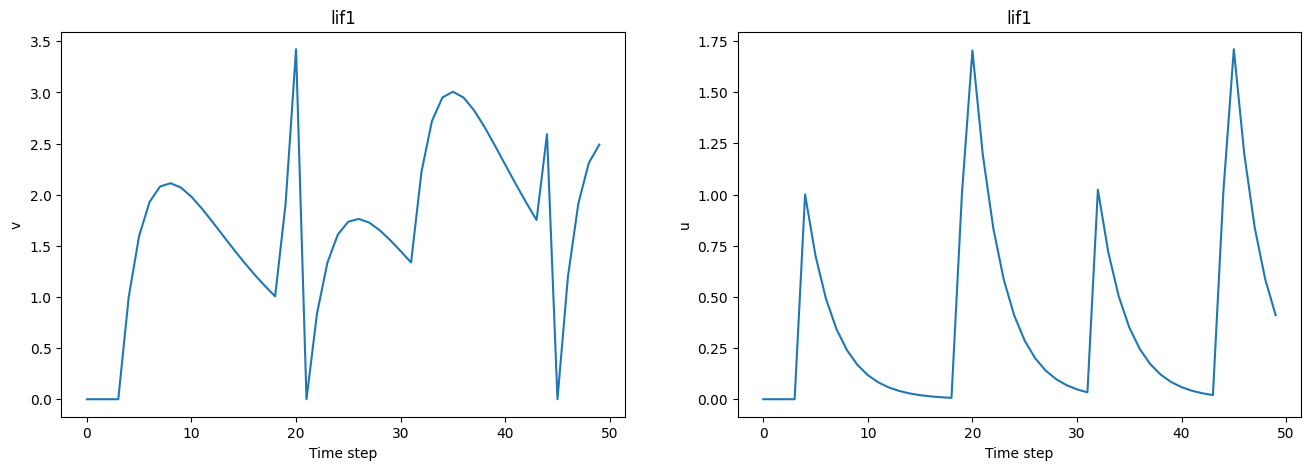

In [91]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitored variable
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax0.set_title('Voltage (V) / time step')
ax1 = fig.add_subplot(122)
ax1.set_title('Current (U) / time step')

# Plot the data
monitor_lif1_v.plot(ax0, lif1.v)
monitor_lif1_u.plot(ax1, lif1.u)


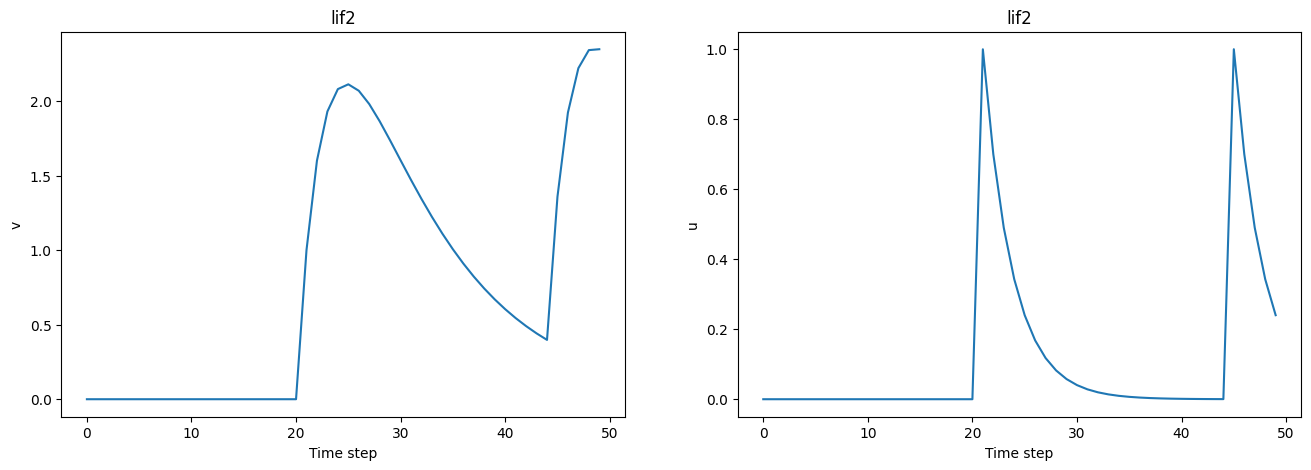

In [92]:
# Create a subplot for each monitored variable of lif2
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax0.set_title('Voltage (V) / time step')
ax1 = fig.add_subplot(122)
ax1.set_title('Current (U) / time step')

# Plot the data
monitor_lif2_v.plot(ax0, lif2.v)
monitor_lif2_u.plot(ax1, lif2.u)

## Find the timesteps where the network bursts occur

In [93]:
voltage_arr = np.array(data_lif1['lif1']['v'])
print("voltage_arr shape:", voltage_arr.shape)

# Iterate the voltage array to find the spikes
spike_times = []
min_voltage_to_spike = v_th / 2
for i in range(len(voltage_arr)):
    # Only considering the voltage of the first neuron
    if voltage_arr[i][0] == 0 and i > 0 and voltage_arr[i-1][0] > min_voltage_to_spike:   # Spike detected
        spike_times.append(i)

print("Spike times: ", spike_times)

voltage_arr shape: (50, 1)
Spike times:  [21, 45]


## Observations

- 

## Stop the Runtime

In [94]:
lif1.stop()